<h1>Real Time Audio Klassifizierung</h1>

Hier wollen wir ein Model erstellen, dass Sound klassifizieren soll. Dan soll das Model in Echtzeit Klassifizierungen durchführen.

Als Startpunkt orientieren wir uns an dem Notebook TF_Audio.

Als zusätzliche Aufgabe sollen die betroffenen stellen der Sounds markiert werden.

Um den Anfang zu machen, wollen wir als Ziel ein Model trainieren, dass Wörter erkennen soll.:
- Ein ASR Model (Automatic-speech-recognition)

Als Dataset nutzen wir:
> Speech Commands dataset (Warden, 2018) <br>
> https://www.tensorflow.org/datasets/catalog/speech_commands [Letzter Zugriff: 5.09.2024]

Dieses Dataset enthält folgende Wörter im Audioformat: "down", "go", "left", "no", "right", "stop", "up" und "yes" <br>

In [2]:
# Imports 
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

import IPython
from IPython import display

import sounddevice as sd
import librosa
from scipy.io import wavfile
from scipy.signal import stft
import wave
from scipy import signal

from sklearn.metrics import classification_report

from scipy.io.wavfile import write
import wavio as wv
from matplotlib.animation import FuncAnimation
import pyaudio
import tensorflow_hub as hub
import pyaudio
import wave
from IPython.display import Audio
import tensorflow_io as tfio

Lade Dataset herunter.

In [168]:
DATASET_PATH = 'data/mini_speech_commands'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

In [169]:
# Dataset enthält Ordner mit Audiodateien.
commands = np.array(tf.io.gfile.listdir(str(data_dir)))

commands = commands[(commands != 'README.md') & (commands != '.DS_Store')]
print(f'Kommandos: {commands}')

Kommandos: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


In [170]:
# Erstelle Dataset # 
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=32,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,  # Padding 
    subset='both')
train_ds

Found 8000 files belonging to 8 classes.
Using 6400 files for training.
Using 1600 files for validation.


<_BatchDataset element_spec=(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [171]:
label_names = train_ds.class_names
train_ds.class_names

['down', 'go', 'left', 'no', 'right', 'stop', 'up', 'yes']

Alternativ können auch nur einige dieser Kommandos oder andere verwendet werden.

<h2>Audio File Analyse</h2>

Dafür eignen sich viele Libraries, generell.:
- scipy
- wave

ML und DL Libraries bieten auch verschiedene Methoden an, um mit Audio zu arbeiten. 

Siehe auch:
- TF: Audio Data Preparation and Augmentation: https://www.tensorflow.org/io/tutorials/audio [Letzter Zugriff: 12.09.2024]
- PT: AUDIO DATA AUGMENTATION: https://pytorch.org/audio/stable/tutorials/audio_data_augmentation_tutorial.html#audio-data-augmentation [Letzter Zugriff: 12.09.2024]
- Audio Data Preparation and Augmentation in Tensorflow: https://www.geeksforgeeks.org/audio-data-preparation-and-augmentation-in-tensorflow/ [Letzter Zugriff: 12.09.2024]

Siehe auch genereller Umgang mit Audio, in TensorFlow z. B. Tensorflow-io.audio

Weiteres kann einfach nachgeschaut werden.

In [6]:
random_command = np.random.randint(1, len(label_names)-1)
random_command = label_names[random_command]

listed_audio_files = os.listdir(DATASET_PATH+f"/{random_command}")

samplerate, data = wavfile.read(DATASET_PATH+f"/{random_command}/{listed_audio_files[6]}")
print(f"Kommando: {random_command}")
print(f"number of channels = {data.shape[0]}")

length = data.shape[0] / samplerate
print(f"Länge = {length}s")

Kommando: stop
number of channels = 16000
Länge = 1.0s


<b>Samplerate</b>: Samples pro Sekunde (Hz)<br>
<b>Data</b>: Stellt die Amplitude der Schallwellen bei jedem Sample dar. Die Struktur ist abhängig von der Anzahl der Channels (mono, stereo) und der Bittiefe. <br>
Mono: 1D, Stereo: 2D, für rechts und links.

Die Bittiefe beschreibt die Range und Genauigkeit der Werte. Jedes Sample repräsentiert durch die Amplitude wie laut es ist. Bei einer Tiefe von 16-Bit sind also 2^16 Werte möglich.

In [8]:
samplerate

16000

In [9]:
data[:10]

array([-1,  2,  2,  2,  2,  2,  2,  2,  2,  2], dtype=int16)

Wenn ein Array vorhanden ist, kann dies mittels `IPython.display.Audio` abgespielt werden.

Damit lassen sich manipulierte Daten direkt abspielen.

In [24]:
Audio(data, rate=16000)

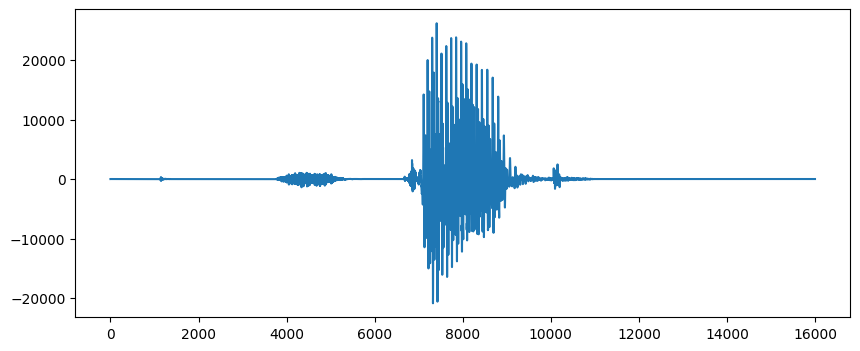

In [10]:
plt.figure(figsize=(10,4))
plt.plot(data)

In [11]:
# Mit Wave # 
wave_audiofile = wave.Wave_read(DATASET_PATH+f"/{random_command}/{listed_audio_files[6]}")

In [12]:
wave_audiofile.getnchannels()
# Auch:
# - max
# - frame_rate
# ...

1

In [13]:
wave_audiofile.getframerate()

16000

Die Channels beschreiben dabei mono oder stereo. Ein Audiosignal was in waveform vorliegt, kann in ein Spektrogramm umgeformt werden, was das Signal in x: Zeit und y: Frequenz aufteilt (siehe Plot), die Pixelwerte geben dabei Stärke der Sounds an, was man auch Dezibel nennt. Da ein Spektrogramm als 2D Bild vorliegt, können herkömmliche CNNs verwendet werden. Da Audio eine Sequenz darstellt, können RNNs und CNN-RNNs verwendet werden.

Genau das ist ein gutes Beispiel für die Verwendung von RNNs bei Bilddaten.

Siehe: <u>Spektrogramm</u>  und <u>Mel-Spektrogramm </u>

- Vergiss nicht zu normalisieren und zu Argumentieren

In [18]:
# Wandel in Spektrogramm um #
# In Tensorflow Style # 
def get_spectrogram(waveform):
    # Short-Time Fourier Transformation: Analysiere Frequenz 
    # - Teile Signal in Frames ein, wende auf Frame Fourier Transformation an.
    # - frame_length: nehme n-Samples für den Frame
    # - frame_step: Overlapping. Seichterer Übergang. 
    spectrogram = tf.signal.stft(waveform, frame_length=255, frame_step=128)
    # Ergebnis sind komplexe Zahlen => berechne Betrag der Zahlen.
    # - Phasenifnromationen werden verworfen und Amplitude behalten
    #   Reich oft für Analyse des Frequenzinhalts.
    spectrogram = tf.abs(spectrogram)  # 2D Repräsentation 
    # Füge eine Achse hinzu, da z. B. CNN ein 3D Tensor erwartet. 
    # - Statt RGB 3D Channel ist es hier ein Greyscale 1D Channel.
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram

In [19]:
# Numpy # 
def get_numpy_spectrogram(samplerate, waveform):

    # Normalisiere, wähle Methode. 
    waveform_normalized = waveform / np.max(np.abs(waveform))
    
    frequenz, times, spectrogram = signal.stft(waveform_normalized, fs=samplerate, nperseg=255, noverlap=128)
    
    spectrogram = np.abs(spectrogram)
    spectrogram = spectrogram[..., np.newaxis]
    # Oder gebe auch frequencies und times zurück
    return spectrogram

In [20]:
def plot_spectrogram(spectrogram):
      if len(spectrogram.shape) > 2:
            assert len(spectrogram.shape) == 3
      spectrogram = np.squeeze(spectrogram, axis=-1)
      # Transponiere: x: Zeit
      # Füge Eps. hinzu, dmait nicht log(0).
      log_spec = np.log(spectrogram.T + np.finfo(float).eps)
      height = log_spec.shape[0]
      width = log_spec.shape[1]
      X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
      Y = range(height)
      plt.figure(figsize=(15,4))
      plt.ylabel('Frequenz [Hz]')
      plt.xlabel('Zeit [s]')
      plt.pcolormesh(X, Y, log_spec)
      plt.colorbar(label='Stärke [dB]')

In [17]:
# Lade .wav Datei #
samplerate, waveform = wavfile.read(DATASET_PATH+f"/{random_command}/{listed_audio_files[6]}")
audio_spectrogram = get_numpy_spectrogram(samplerate, waveform)
audio_spectrogram

array([[[9.70576193e-06],
        [2.56098786e-05],
        [5.14681458e-06],
        ...,
        [2.72608531e-05],
        [1.68883948e-05],
        [1.13960825e-05]],

       [[1.99844398e-05],
        [2.14106820e-05],
        [7.85763455e-06],
        ...,
        [2.02582155e-05],
        [6.87478430e-06],
        [2.05669863e-05]],

       [[2.56764705e-05],
        [1.28379084e-05],
        [5.48629966e-06],
        ...,
        [1.00374384e-05],
        [4.09602272e-05],
        [2.75281469e-05]],

       ...,

       [[4.02872135e-07],
        [1.35393076e-06],
        [8.88580029e-07],
        ...,
        [6.84896632e-07],
        [5.27035951e-07],
        [8.77867587e-07]],

       [[6.20989334e-07],
        [1.01341200e-06],
        [1.28612585e-06],
        ...,
        [1.19155274e-06],
        [6.96278469e-07],
        [8.67731119e-07]],

       [[9.43681846e-07],
        [6.67647793e-07],
        [6.52846147e-07],
        ...,
        [7.34469082e-07],
        [2.8142

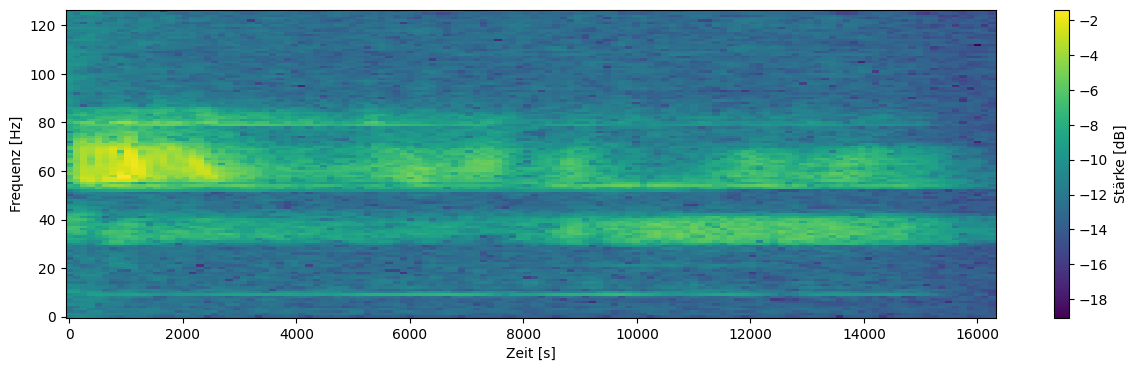

In [18]:
plot_spectrogram(audio_spectrogram)

Mit TensorFlow würde man das so angehen:

In [19]:
# Entferne eine Achse, da Single-Channel # 
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds   = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [20]:
example_audio_signals = []
for example_audio, example_labels in train_ds.take(1):  
      example_audio_signals.append(example_audio)

In [21]:
tf_audio_spectrogram = get_spectrogram(example_audio_signals[0])[0]

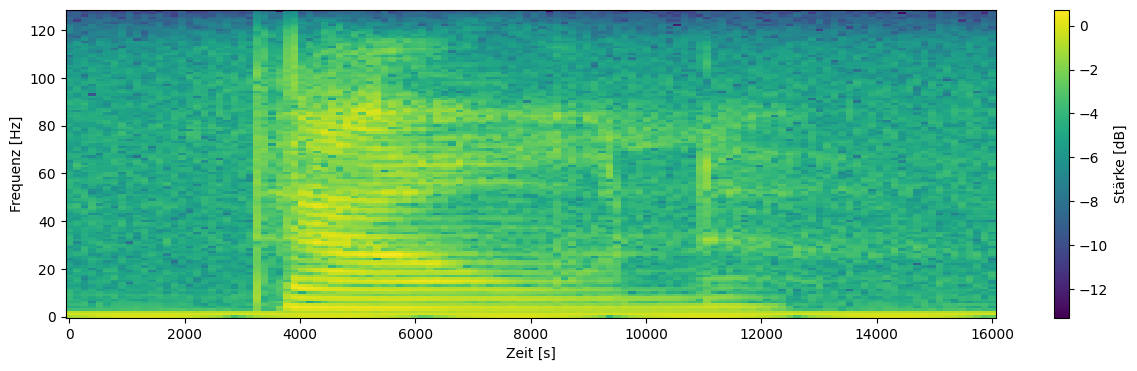

In [22]:
plot_spectrogram(tf_audio_spectrogram)

In [22]:
tf_audio_spectrogram

<tf.Tensor: shape=(124, 129, 1), dtype=float32, numpy=
array([[[3.3032542e-01],
        [8.6649549e-01],
        [4.3549162e-01],
        ...,
        [9.5320996e-05],
        [1.0116023e-04],
        [4.6804547e-05]],

       [[3.8123477e-01],
        [8.4070766e-01],
        [4.2384359e-01],
        ...,
        [1.1630582e-04],
        [1.5406140e-04],
        [6.0647726e-05]],

       [[4.8545671e-01],
        [8.5349751e-01],
        [4.3315887e-01],
        ...,
        [2.5949392e-05],
        [6.0158145e-05],
        [2.3856759e-05]],

       ...,

       [[1.3450077e-01],
        [8.4713757e-01],
        [4.1132620e-01],
        ...,
        [5.0299474e-05],
        [6.2675834e-05],
        [6.6310167e-05]],

       [[6.6373229e-02],
        [8.4855998e-01],
        [4.1165495e-01],
        ...,
        [5.1328632e-05],
        [8.2641182e-06],
        [2.0094216e-05]],

       [[8.3473578e-02],
        [8.6038220e-01],
        [4.2065221e-01],
        ...,
        [1.3905462e

<h2>Model und Dataset</h2>

Jetzt bereiten wir das Dataset vor und erstellen das Model.

In [23]:
# Erstelle Test- und Validationset #
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds  = val_ds.shard(num_shards=2, index=1)

Dann die Daten in ein Spektrogramm umwandeln.

In [21]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [25]:
train_ds_spec = make_spec_ds(train_ds)
val_ds_spec   = make_spec_ds(val_ds)
test_ds_spec  = make_spec_ds(test_ds)

Dann erstellen wir das Model.

In [26]:
input_shape = tf_audio_spectrogram.get_shape()
num_classes = len(label_names)

norm_layer = tf.keras.layers.Normalization()
norm_layer.adapt(data=train_ds_spec.map(map_func=lambda spec, label: spec))

sound_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=input_shape),
    # ---
    tf.keras.layers.Resizing(80, 90),
    # ---
    norm_layer,
    # ---
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)), 
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)), 
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)), 
    # ---
    # Reshape für RNN
    # ---
    tf.keras.layers.Reshape((-1, 128)),
    tf.keras.layers.LSTM(64, return_sequences=False),
    #tf.keras.layers.LSTM(128, return_sequences=False),
    # --
    tf.keras.layers.Dense(units=64, activation="relu"),
    tf.keras.layers.Dropout(0.24),
    #tf.keras.layers.Dense(units=32, activation="relu"),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=num_classes),  # activation="softmax"
])


sound_model.compile(
    optimizer='adam',
    loss     = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics  = ["accuracy"]
)


tf_callback = tf.keras.callbacks.TensorBoard(log_dir="logs/real_time_audio/sound_model", histogram_freq=1)

sound_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing (Resizing)             │ (None, 80, 90, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization (Normalization)   │ (None, 80, 90, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 78, 88, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 39, 44, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 37, 42, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 18, 21, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 19, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 72, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 146,763 (573.30 KB)

 Trainable params: 146,760 (573.28 KB)

 Non-trainable params: 3 (16.00 B)

In [112]:
history_base = sound_model.fit(train_ds_spec, validation_data=val_ds_spec, epochs=35, batch_size=32, callbacks= [tf_callback])

Epoch 1/35
200/200 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - accuracy: 0.1690 - loss: 1.9974 - val_accuracy: 0.2988 - val_loss: 1.6637
Epoch 2/35
200/200 ━━━━━━━━━━━━━━━━━━━━ 11s 55ms/step - accuracy: 0.3300 - loss: 1.6066 - val_accuracy: 0.3638 - val_loss: 1.4947
Epoch 3/35
200/200 ━━━━━━━━━━━━━━━━━━━━ 11s 57ms/step - accuracy: 0.3880 - loss: 1.4356 - val_accuracy: 0.4600 - val_loss: 1.3083
Epoch 4/35
200/200 ━━━━━━━━━━━━━━━━━━━━ 11s 56ms/step - accuracy: 0.4857 - loss: 1.2171 - val_accuracy: 0.5562 - val_loss: 1.1290
Epoch 5/35
200/200 ━━━━━━━━━━━━━━━━━━━━ 12s 58ms/step - accuracy: 0.5715 - loss: 1.0597 - val_accuracy: 0.6413 - val_loss: 0.8980
Epoch 6/35
200/200 ━━━━━━━━━━━━━━━━━━━━ 11s 56ms/step - accuracy: 0.6514 - loss: 0.8762 - val_accuracy: 0.7063 - val_loss: 0.8225
Epoch 7/35
200/200 ━━━━━━━━━━━━━━━━━━━━ 11s 57ms/step - accuracy: 0.6802 - loss: 0.8409 - val_accuracy: 0.7250 - val_loss: 0.7341
Epoch 8/35
200/200 ━━━━━━━━━━━━━━━━━━━━ 11s 57ms/step - accuracy: 0.7202 - loss: 0.7405 - 

In [113]:
sound_model.evaluate(test_ds_spec)

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9112 - loss: 0.3619


[0.32269448041915894, 0.9137499928474426]

In [390]:
# Tensorboard
! tensorboard --logdir logs/real_time_audio/

^C


In [114]:
pred = sound_model.predict(test_ds_spec)

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


In [115]:
pred_argmax =  [ np.argmax(i) for i in pred ]
pred_argmax = np.array(pred_argmax)

y_true = tf.concat(list(test_ds_spec.map(lambda s,lab: lab)), axis=0)

In [116]:
print(classification_report(pred_argmax, y_true))

              precision    recall  f1-score   support

           0       0.88      0.91      0.90        94
           1       0.94      0.82      0.87       127
           2       0.92      0.95      0.94       102
           3       0.84      0.89      0.87        95
           4       0.95      0.94      0.95        86
           5       0.87      0.98      0.92       100
           6       0.97      0.89      0.93       100
           7       0.96      0.95      0.95        96

    accuracy                           0.91       800
   macro avg       0.92      0.92      0.92       800
weighted avg       0.92      0.91      0.91       800



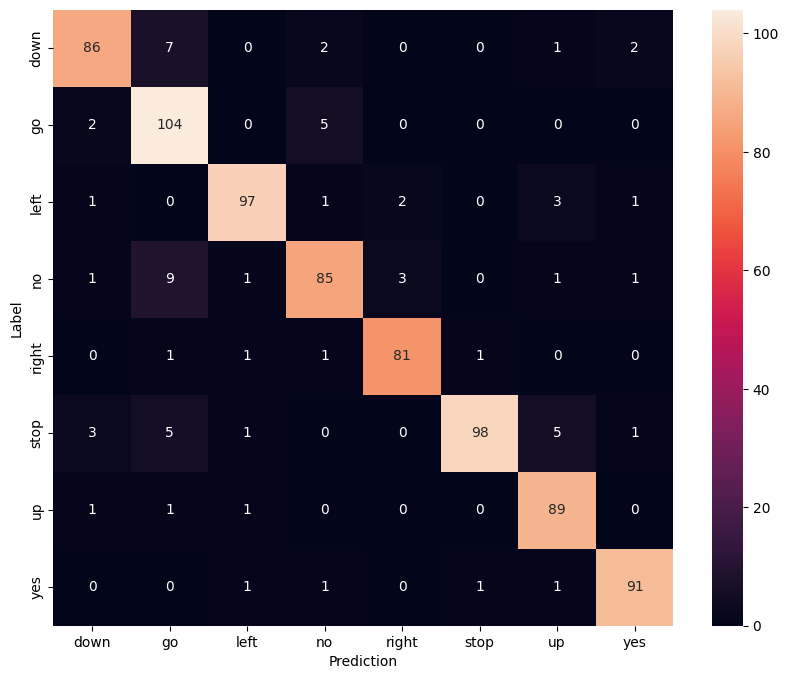

In [117]:
confusion_mtx = tf.math.confusion_matrix(y_true, pred_argmax)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

Dann soll das Model gespeichert werden.

In [118]:
# Speichere
sound_model.save_weights("./data/data/saved_models/sound_model.weights.h5")
# Lade
#sound_model.load_weights("./data/data/saved_models/sound_model.weights.h5")

<h2>Predictions</h2>

In [84]:
# Lade Model # 
sound_model.load_weights("./data/data/saved_models/sound_model.weights.h5")

sound_model.compile(
    optimizer='adam',
    loss     = tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics  = ["accuracy"]
)

C:\Users\Alexander\anaconda3\envs\tensorflow\lib\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 28 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [85]:
sound_model.evaluate(test_ds_spec, return_dict=True)

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.9112 - loss: 0.9504


{'accuracy': 0.9137499928474426, 'loss': 0.9272232055664062}

<h3>Eigene Aufnahmen</h3>

Im folgendem können eigene Aufnahmen erstellt werden, die dann ggf. verarbeitet und dann für Predictions genutzt werden können.

In [28]:
# Aufnahme mit Mikrofon 
# - Oder wähle andere Methode... 
# Frequenz: 
freq = 16000
# Aufnahmezeit: 
record_time = 3

# Nehme mit Mikrofon auf
def record_audio(record_time=3):
    print("Starte Aufnahme")
    audio = sd.rec(int(freq * record_time), samplerate=freq, channels=1)
    sd.wait()  
    print("Aufnahme beendet")
    return np.squeeze(audio)

In [126]:
mic_audio = record_audio()

Starte Aufnahme
Aufnahme beendet


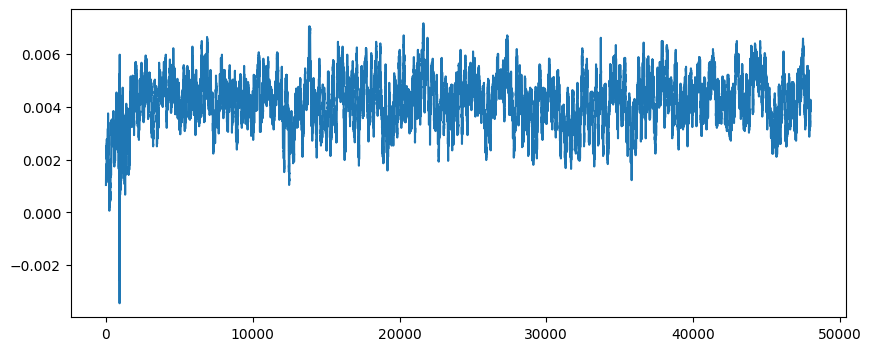

In [127]:
plt.figure(figsize=(10, 4))
plt.plot(mic_audio)

In [128]:
# GGf. weitere Analysen.

In [129]:
# Speichere Audio
write("mic_record.wav", freq, mic_audio)

Lade oder zeige an.

In [130]:
# Auch mit HTML möglich, siehe HTML usage in Notebooks. 
IPython.display.Audio("mic_record.wav")

<h3>Einzelne Prediction</h3>

Jetzt können wir einzelne Predictions durchführen. Gut geeignet für Audiosamples die fast die gleiche Länge haben mit dem das Model trainiert wurde.

<b>*</b>Achte auf die Normalisierung und andere Transformationen die vorgenommen werden müssen, bevor eine Predictions durchgeführt wird. 

In [194]:
# Für ein einfaches wiedergeben 
dict_labels = {0:"down", 1:"go",2:"left",3:"no",4:"right",5:"stop",6:"up",7:"yes",}
dict_labels

{0: 'down',
 1: 'go',
 2: 'left',
 3: 'no',
 4: 'right',
 5: 'stop',
 6: 'up',
 7: 'yes'}

In [72]:
# Gebe Zahl oder Label aus. 
# *Gut für Audiosignale die auch ~ 1s lang sind. 
# - Input: Numpy Waveform 
def make_single_prediction(model, data, freq:int=16000, return_class=False, return_all=False):
    # ** 16-Bit Audio -> 32768.0

    audio = np.asarray(waveform.astype(np.float32) / 32768.0 ) # Normalisiere
    spec =  get_spectrogram(audio)
    spec = spec[tf.newaxis, ...]

    prediction = sound_model(spec)
    
    if return_class:
        return np.argmax(tf.nn.softmax(prediction))
    elif return_all:
        return {np.argmax(tf.nn.softmax(prediction)): prediction}
    else:
        return prediction

Wir können das mit dem Dataset testen.

In [31]:
# Lade Waveform und spiele ab # 
command = "right"
audio_sample_index = 70
listed_audio_files = os.listdir(DATASET_PATH+f"/{command}")

_, waveform = wavfile.read(DATASET_PATH+f"/{command}/{listed_audio_files[audio_sample_index]}")  # gebe Index an, oder zufällig...

IPython.display.Audio(DATASET_PATH+f"/{command}/{listed_audio_files[audio_sample_index]}")

Führe Predictions aus.:

In [32]:
make_single_prediction(sound_model, waveform, return_class=True)

4

In [33]:
# Random # 
rdm_command_index = np.random.randint(0, 7)
rdm_command = dict_labels[rdm_command_index]
audio_sample_index = np.random.randint(0, 50)
listed_audio_files = os.listdir(DATASET_PATH+f"/{rdm_command}")
print(f"Kommando: {rdm_command}, Klasse: {rdm_command_index}")
_, waveform = wavfile.read(DATASET_PATH+f"/{rdm_command}/{listed_audio_files[audio_sample_index]}")  # gebe Index an, oder zufällig...

print(f"Prediction: {make_single_prediction(sound_model, waveform, return_class=True)}")

IPython.display.Audio(DATASET_PATH+f"/{rdm_command}/{listed_audio_files[audio_sample_index]}")



Kommando: down, Klasse: 0
Prediction: 0


Mit eigener Aufnahme: 

In [34]:
# Teste mit verschiedenen Aufnahmezeiten # 
mic_audio = record_audio(record_time=3)
write("mic_record.wav", freq, mic_audio)
IPython.display.Audio("mic_record.wav")

Starte Aufnahme
Aufnahme beendet


In [35]:
make_single_prediction(sound_model, mic_audio, return_class=True)

0

<h3>Split Audio und Padding</h3>

Bei längeren Audiosignalen die z. B. 10-Sekunden klang sind, müssen diese in Schnipsel zerlegt werden.

<b>*</b>Es gibt verschiedene Ansätze ein längeres Audiosignal für eine Predictions zu nutzen, Streaming wäre auch möglich. Besonders wichtig wird es bei Real Time Predictions.

<u>Bevor</u> wir eigene Aufnahmen nutzen, testen wir den Aufbau mit den vorhanden Audiosignalen. Um die Aufnahmen zu verlängern, nutzen wir eine Paddingmethode um z. B. Nullen einzufügen. Damit können dann die Waveformdataien auf 10 Sekunden gestreckt werden.

Hier nutzen wir den Ansatz Slidning-Window.

In [36]:
# Teile Audio in Frames ein. #
# - Slidning-Window
def split_audio_in_frames(audio, frame_length, frame_step, sample_rate:int=16000):
    frame_samples      = int(frame_length * sample_rate)
    frame_step_samples = int(frame_step   * sample_rate)

    # frame_length: Wie lange ein Frame sein soll. Hier: 1s, wegen Trainingsdaten.
    # frame_step:   Schrittweite des Frames

    # Nutze Slinding Window mit Overlap #
    audio_frames = []
    for i in range(0, len(audio) - frame_samples + 1, frame_step_samples):
        frame = audio[i:i+frame_samples]  # Fesnter 
        # Diese Frames dann für Prediction nutzen. #
        audio_frames.append(frame)
    return np.array(audio_frames)

Anders als wie oben, nutzen wir alle n-Frames für doe Prediction. <br>
<b>*</b>Wenn ein Signal keine bedeutsamen Inhalte hat, geben wir nichts aus oder sagen, dass es an dieser Stelle nichts gibt. Das können wir machen, indem wir einen threshold angeben, ab wann ein Signal als Klasse gilt, z. B. ein Wert höher als 0.6 ist eine Klassifizierung, alles darunter ist keine Klasse. Das gilt auch für andere Probleme und Anwendungen.

In [37]:
# Predictions auf alle oder einzelne Frames # 
def predict_on_audioFrames(model, frames, threshold:int=0.68):
    # Sammmel Preditions oder gebe nur eine Antwort aus.
    prediction_list = []  # Pro Frame
    # Hier kann auch z. B. nur ausgegeben werden, ob ein bestimmtes Geräusch entdeckt wurde, mit 0 der 1.
    for frame in frames:
        audio = np.asarray(frame.astype(np.float32) / 32768.0 ) # Normalisierem.  16-Bit Audio. 
        spec  = get_spectrogram(audio)
        spec  = spec[tf.newaxis, ...]

        prediction = model.predict(spec)
        prediction = tf.nn.softmax(prediction)

        if True in (prediction >= threshold)[0]:  # Klasse endeckt. 
            class_index = np.argmax(prediction)
            prediction_list.append(class_index)
        else:
            prediction_list.append(-1)  # Keine Klasse -> -1, oder was ähnliches...  
    return prediction_list

Jetzt wählen wir eine einige Dateien aus und nutzen Padding. Danach werden diese für die Predictions genutzt, am Ende sehen wir wie gut der Slidning-Window Ansatz für längere Aufnahmen funktioniert.

In [38]:
# Funktion für Padding # 
def pad_audio(audio, freq, padding_s):
    pad_length   = int(padding_s * freq)  
    # Padding auf beiden Seiten
    # - Siehe np.pad() für mehr Info. 
    padded_audio = np.pad(audio, (pad_length, pad_length), mode='constant', constant_values=0)
    return padded_audio

In [39]:
dict_labels

{0: 'down',
 1: 'go',
 2: 'left',
 3: 'no',
 4: 'right',
 5: 'stop',
 6: 'up',
 7: 'yes'}

In [40]:
test_audio = []
command = "yes"
listed_audio_files = os.listdir(DATASET_PATH+f"/{command}")
print(f"Kommando: {command}")
for i in range(4):
    samplerate, waveform = wavfile.read(DATASET_PATH+f"/{command}/{listed_audio_files[i]}")
    test_audio.append(waveform)

Kommando: yes


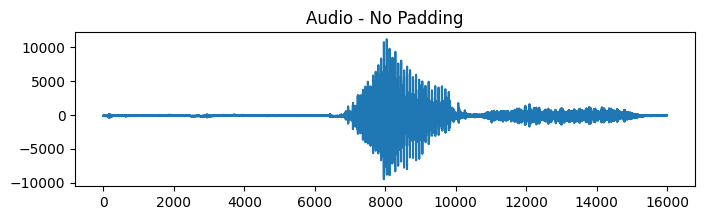

In [41]:
plt.figure(figsize=(8, 2))
plt.title("Audio - No Padding")
plt.plot(test_audio[0])

In [42]:
padded_audio = pad_audio(test_audio[0], 16000, 4.5)

print(f'Original [s]:     {len(test_audio[0]) / 16000} s')
print(f'Padded audio [s]: {len(padded_audio) / 16000} s')

Original [s]:     1.0 s
Padded audio [s]: 10.0 s


<b>*</b>Es gibt auch andere Möglichkeiten und Werte die man nutzen kann.

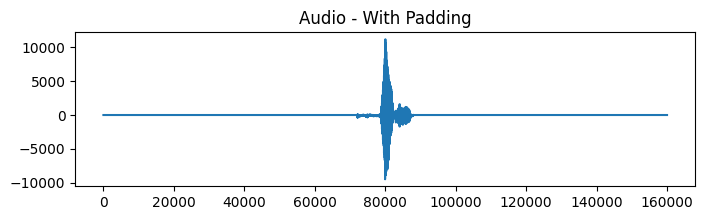

In [43]:
plt.figure(figsize=(8, 2))
plt.title("Audio - With Padding")
plt.plot(padded_audio)

Die einzelnen Frames, die nach der Zerteilung entstehen, können wir uns anzeigen lassen.

In [44]:
# Split Audio # 
split_record = split_audio_in_frames(padded_audio, 1, 0.5)
len(split_record)

19

In [549]:
# Plotte Frames # 
def plot_split_audio(frames:np.array, figheight=12,figwidth=12):

    len_frames  = len(frames)
    plot_number = len_frames
   
    fig, axs = plt.subplots(int(np.ceil(plot_number/4)), 4)
    fig.tight_layout(pad=1)
    fig.set_figwidth(figwidth)
    fig.set_figheight(figheight)
    
    offset = 0
    for i in range(int(np.ceil(plot_number/4))):
        for ii in range(4):
            if ii+offset==len_frames: 
                del_index = ii
                while(del_index%4!=0):                   
                    fig.delaxes(axs[i][del_index])
                    del_index+=1
                break
            axs[i, ii].set_title(f"Frame Index: {ii+offset}")
            axs[i, ii].plot(frames[ii+offset])
        offset+=4

len frams 19
ii 3
6


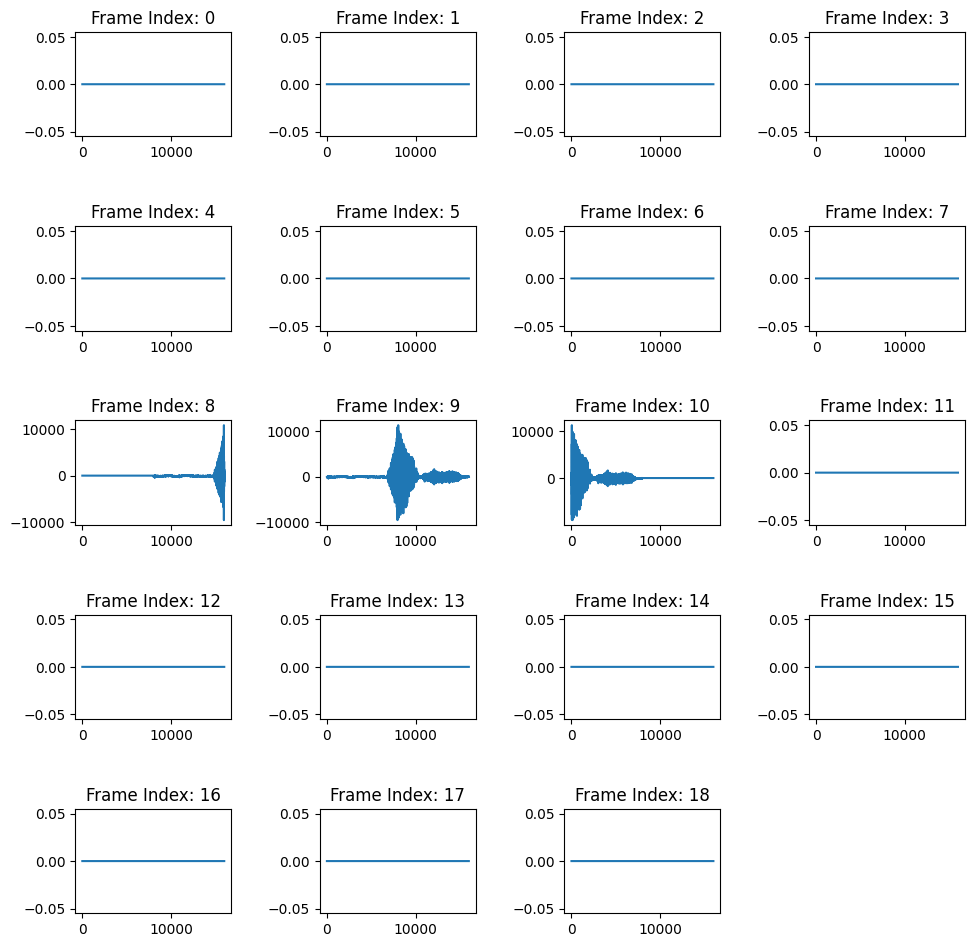

In [520]:
# Stelle ggf. größe ein und weitere Optionen. 
plot_split_audio(split_record, figheight=10,figwidth=10)

In diesen 19 Frames sehen wir das Frame 9 die besten Voraussichten bietet, da das Signal hier vollständig ist, der Rest ist egal. Die Ränder Frame 8 und Frame 10 könnten auch gute Ergebnisse liefern. 

Zusätzlich können wir visualisieren  wie das Model verschiedene Frame sehen würde.

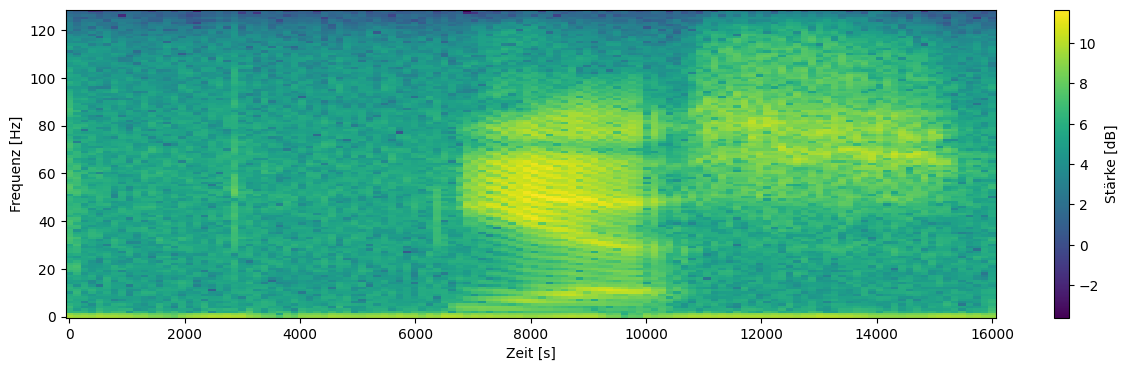

In [47]:
spec_tf = get_spectrogram(np.array(split_record[9], dtype=np.float32))
plot_spectrogram(spec_tf)

In [48]:
# Einzelne Frames 
frame_index = 17
make_single_prediction(sound_model, split_record[frame_index], return_class=True)

7

In [49]:
dict_labels

{0: 'down',
 1: 'go',
 2: 'left',
 3: 'no',
 4: 'right',
 5: 'stop',
 6: 'up',
 7: 'yes'}

In [50]:
test_audio = []
command = "up"
listed_audio_files = os.listdir(DATASET_PATH+f"/{command}")
print(f"Kommando: {command}")

samplerate, waveform = wavfile.read(DATASET_PATH+f"/{command}/{listed_audio_files[7]}")

wave_padding = pad_audio(waveform, 16000, 4.5)
wave_padding_split = split_audio_in_frames(wave_padding, 1, 0.5)

Kommando: up


In [51]:
res = predict_on_audioFrames(sound_model, wave_padding_split)
res

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


[-1, -1, -1, -1, -1, -1, -1, -1, -1, 6, 6, -1, -1, -1, -1, -1, -1, -1, -1]

Jetzt haben wir den <u>Index</u> und die <u>Klasse</u> in einer Ausgabe. Die Ausgabe bzw. Funktion kann man weiter verfeinern.

In [52]:
# Gebe Index und Klasse aus #
frames = [ [i, el] for i, el in enumerate(res) if el != -1]
frames 
# Für Index schaue oberen Plot an 

[[9, 6], [10, 6]]

<h2>Markiere Frames</h2>

Zusätzlich können wir in dem Plot des Audiosignals die betroffenen Stellen markieren und visualisieren. Das kann live bei der Aufnahme gemacht werden oder offline für längere Audioausschnitte. Hier gib es wieder viele Möglichkeiten.

Ein Plot kann ganz einfach erstellt werden.

In [75]:
# Markiere Klasse im Audiosignal #
# - Hier können weitere Inhalte eingezeichnet werden.
def mark_detection(audio, predictions_frames, frame_step:float, frame_length:int, fig_size=(10, 4), freq:int=16000):
    time_line = np.linspace(0, len(audio) / freq, num=len(audio) )
    # GGf. Plot weiter anpassen.
    plt.figure(figsize=fig_size)
    plt.xlabel("Zeit [s]")
    plt.ylabel("Amplitude")
    plt.plot(time_line, audio)

    for i, pred in enumerate(predictions_frames):
        # Gehe über n-Frames
        if pred != -1:
            # Weitere Elemente / Details können eingezeichnet werden # 
            start_time = i * frame_step
            end_time   = start_time + frame_length
            # Siehe: matplotlib.pyplot.axvspan() | 
            # - Wir Zeichnen Kasten, für andere Methoden siehe Doks. # 
            plt.axvspan(start_time, end_time, color='red', alpha=0.5, label=f"Klasse Erkannt: {pred}")  # Zeichne Bereich ein
    plt.legend()
        

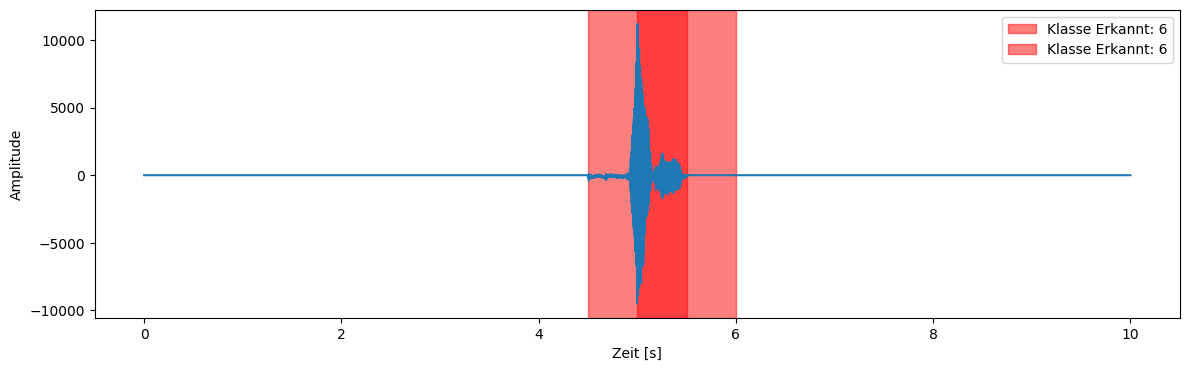

In [54]:
# Window: 1s, step: 0.5, siehe oben. 
mark_detection(padded_audio, res, frame_step=0.5, frame_length=1, fig_size=(14, 4))

Jetzt können wir auch mehrere Audioclips zusammenfügen und diese in Frames aufteilen. Dann sehen wie gut die Methode funktioniert, wenn mehrere Klassen in einer Sequenz existieren.

Für das Aneinanderhängen von Audioclips können die Arrays einfach konkateniert werden. Es gibt auch Libraries die direkt mit "+" Waveformdateien konkatenieren können.

In [55]:
dict_labels

{0: 'down',
 1: 'go',
 2: 'left',
 3: 'no',
 4: 'right',
 5: 'stop',
 6: 'up',
 7: 'yes'}

In [56]:
# Wähle Clips # 
commandos = ["yes", "left", "down"]

yes_list  = os.listdir(DATASET_PATH+f"/{commandos[0]}")
left_list = os.listdir(DATASET_PATH+f"/{commandos[1]}")
down_list = os.listdir(DATASET_PATH+f"/{commandos[2]}")

_, yes_data  = wavfile.read(DATASET_PATH+f"/{commandos[0]}/{yes_list[7]}")
_, left_data = wavfile.read(DATASET_PATH+f"/{commandos[1]}/{yes_list[7]}")
_, down_data = wavfile.read(DATASET_PATH+f"/{commandos[2]}/{yes_list[7]}")

yes_data_pad   =  np.array( pad_audio(yes_data, 16000, 1))
left_data_pad  =  np.array(pad_audio(left_data, 16000, 1))
down_data_pad  =  np.array(pad_audio(down_data, 16000, 1))

In [57]:
final_audio = np.concatenate((yes_data_pad, left_data_pad))
final_audio = np.concatenate((final_audio, down_data_pad))

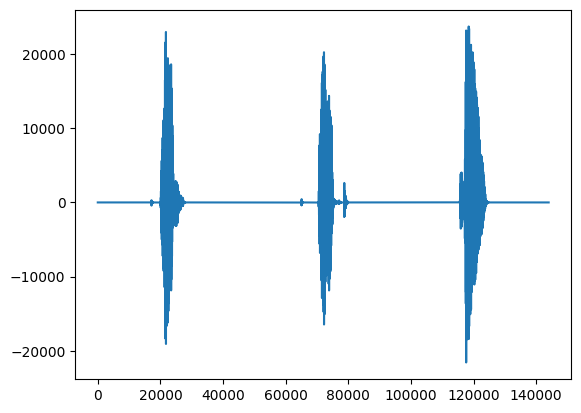

In [58]:
plt.plot(final_audio)

In [521]:
final_audio_splits  =  split_audio_in_frames(final_audio, 1, 0.5 )
len(final_audio_splits)

17

2
3
4


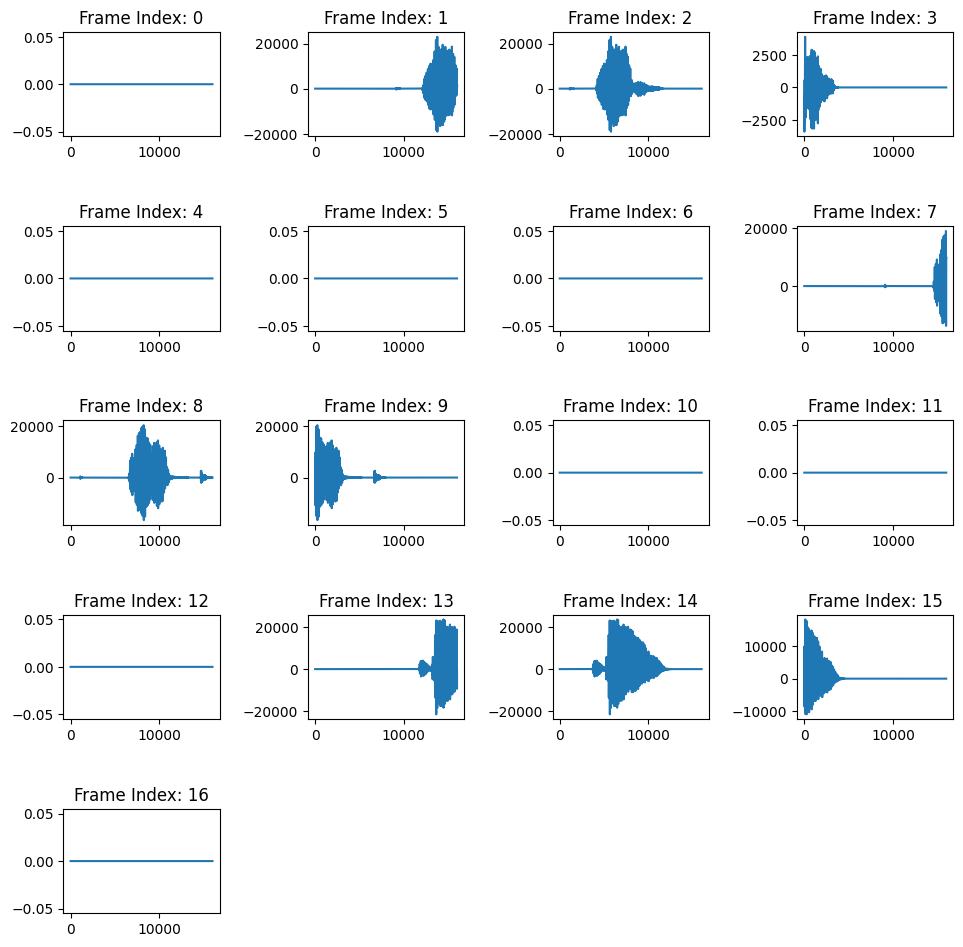

In [526]:
plot_split_audio(final_audio_splits, figheight=10,figwidth=10)

In [61]:
res = predict_on_audioFrames(sound_model, final_audio_splits)
res

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


[-1, -1, 7, 7, -1, -1, -1, -1, 2, -1, -1, -1, -1, -1, 0, -1, -1]

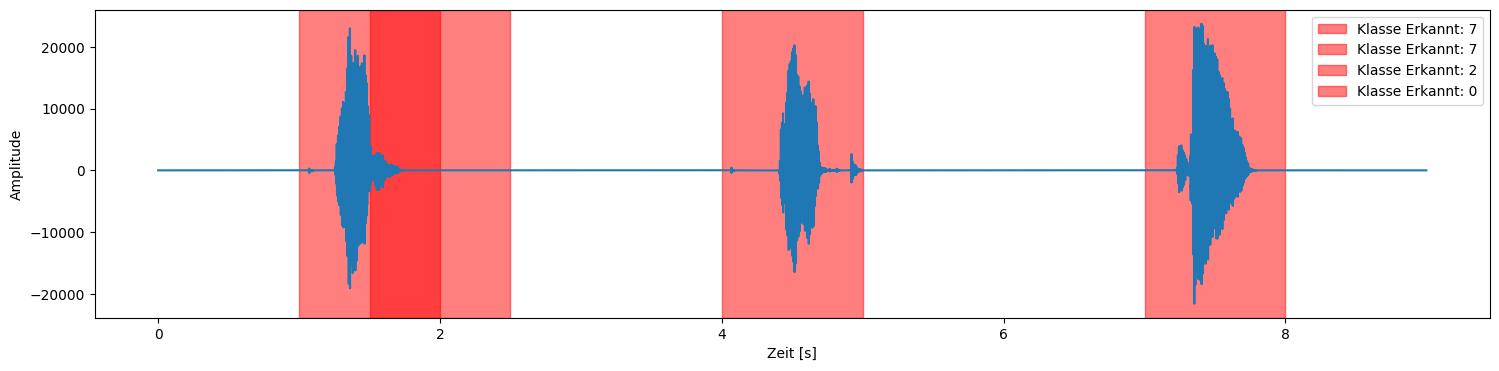

In [91]:
mark_detection(final_audio, res, frame_step=0.5, frame_length=1, fig_size=(18, 4))

Das Spiel könnte man noch weiter treiben und weitere Features implementieren.

Den Plot könnte man auch weiter Anpassen, für unseren Zweck reicht es.

<h2>Real Time Audioklassifizierung</h2>

Bei der Klassifizierung von Audio in Echtzeit sind die Ansätze sehr ähnlich wie bei den oberen Methoden. Für die Predictions werden einzelne Frames benötigt.

Hier ist es wieder wichtig wie die Frames eingeteilt werden. Bei dem Stream sollte sichergestellt werden, das Frames nahezu 1 Sekunde lang sind. Dabei sollte auch ein Overlap von n-Sekunden verwendet werden. Hier gibt es wieder mehrere Möglichkeiten. 

Um direkt Feedback zu bekommen, können Ausgaben erzeugt werden die Klassen und Frame-IDs wiedergeben. Zudem können alle Frames geplottet werden, was visualisiert welche Frames welche Klassen wiedergeben.

In [201]:
dict_labels

{0: 'down',
 1: 'go',
 2: 'left',
 3: 'no',
 4: 'right',
 5: 'stop',
 6: 'up',
 7: 'yes'}

In [555]:
# Prototyp- Lese Stream und führe Prediction aus # 

# * 16-Bit Audio -> 32K 
# - Achte auf Formate und Inhalt: Samplerate, Fenstergröße, ...
# - Hier können auch Prozesse und Threads verwendet werden

# Parameter # 
# - Passe und siehe Ergebnis
#   -> Plote 
# Gut mit:
# - CHUNK 16000 und 8000 | FRAME_LENGTH 3 * CHUNK und 2 * CHUNK,  1 * CHUNK
def run_stream_and_predict():
    CHUNK = 16000  # 8000,  16000: 5.0s Audio.  32000: 1s Audio. 
    FORMAT   = pyaudio.paInt16
    CHANNELS = 1
    RATE     = 16000  # Samplerate in Hz
    RECORD_SECONDS  = 10   #  Aufnahmezeit 
    OVERLAP_SECONDS = 0.5  # Schrittweite des Fensters
    FRAME_LENGTH    = 2 * CHUNK  #3 * CHUNK,  2 * CHUNK:  1s Audio,  da 32.000 eine 1s Audio ist.

    # Oder nutze andere Library 
    p = pyaudio.PyAudio()

    # Erstelle Stream # 
    stream = p.open(format=FORMAT,
                channels=CHANNELS,
                rate=RATE,
                input=True,
                frames_per_buffer=CHUNK)

    print(">> Stream gestartet")
    # Sammel Frames 
    frames = []
    # Puffer für 1s Audio (32000 Samples)
    buffer = np.zeros(FRAME_LENGTH, dtype=np.int16)

    total_stream_data = []  
    
    max_frames = int((RATE / CHUNK) * RECORD_SECONDS)
    for i in range(0, max_frames):
        # Lese Chunk des Audiostreams
        data        = stream.read(CHUNK)
        total_stream_data.extend(data)
        audio_chunk = np.frombuffer(data, dtype=np.int16)
        
        # Shift the existing buffer by 0.5 seconds and append the new 0.5 seconds
        # Schiebe nach links um CHUNK-Größe: n-Sekunden
        buffer = np.roll(buffer, -CHUNK)  
        buffer[-CHUNK:] = audio_chunk  # Füge CHUNK am Ende ein. 
        
        # Puffer hat jetzt n-Sekunden Audio.
        frames.append(buffer.copy())  # Füge Frame für Prediction und sonstiges ein. 
    
        ######################## Pred ########################
        if run_prediction:
            # * Wenn Frame Sekunden < 1-Sekunde => Nutze Padding 
            #audio_norm = np.asarray(pad_audio(buffer, 16000, 0.12 ).astype(np.float32) / 32768.0 )  
            audio_norm = np.asarray(buffer.astype(np.float32) / 32768.0 )  
            spec  = get_spectrogram(audio_norm)[tf.newaxis, ...]
            pred = tf.nn.softmax(sound_model.predict(spec))
            
            if True in (pred>=0.68)[0]:
                    print(f"Frame {i+1}/{max_frames} | Klasse: {np.argmax(pred)}, {dict_labels[np.argmax(pred)]} ")
            else:
                print(f"Frame {i+1}/{max_frames} | Klasse: --- {-1} --- ")
        

    print("> > Stop des Streams.")
    
    # Clean up
    stream.stop_stream()
    stream.close()
    p.terminate()
    
    return frames, total_stream_data

In [556]:
collected_frames, whole_stream_data = run_stream_and_predict()

>> Stream gestartet
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Frame 1/10 | Klasse: 6, up 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Frame 2/10 | Klasse: 6, up 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Frame 3/10 | Klasse: 6, up 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Frame 4/10 | Klasse: --- -1 --- 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Frame 5/10 | Klasse: --- -1 --- 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Frame 6/10 | Klasse: --- -1 --- 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Frame 7/10 | Klasse: 4, right 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Frame 8/10 | Klasse: 2, left 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Frame 9/10 | Klasse: --- -1 --- 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Frame 10/10 | Klasse: --- -1 --- 
> > Stop des Streams.


Jetzt die Frames geplotet werden.

In [558]:
collected_frames[0].shape[0] / 16000

2.0

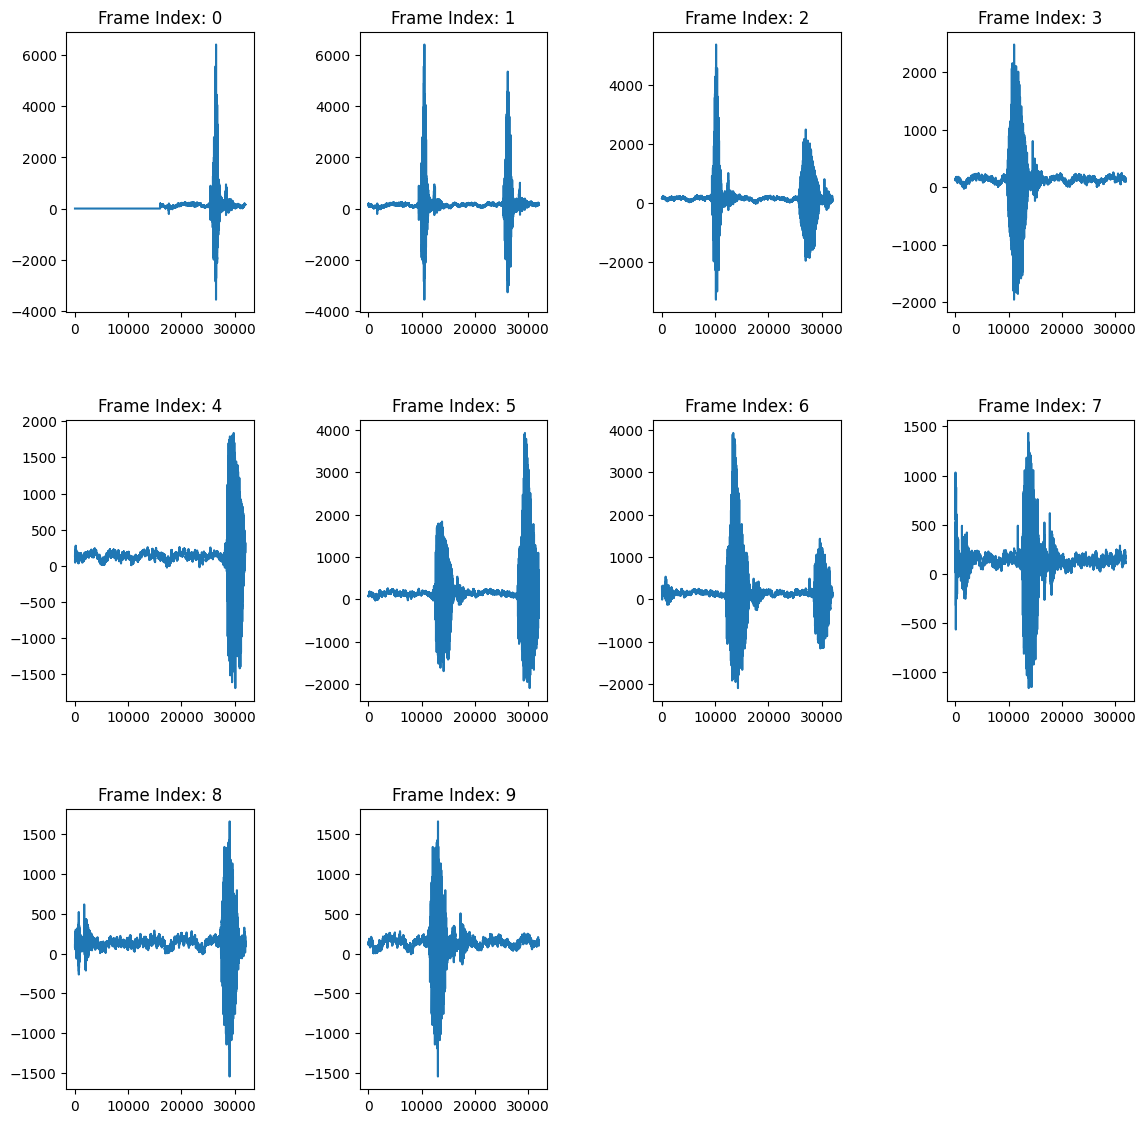

In [559]:
plot_split_audio(collected_frames)

In [561]:
res = predict_on_audioFrames(sound_model, collected_frames)
res

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


[6, 6, 6, -1, -1, -1, 4, 2, -1, -1]

<h1>Sonstiges</h1>

<h2>Data Argumentation</h2>

Wie auch bei Bilddaten und anderen kann Data Argumentation verwendet werden, um die Daten zu manipulieren, was Overfitting reduziert. <br>
Beispiele für Data Argumentation:
- Trimmen
- Rauschen
- Filtern
- Daten hinzufügen / entfernen
- Verschiebungen
- ...

Siehe: [Audio File Analyse]

In [25]:
# Lese Datei # 
random_command = np.random.randint(1, len(label_names)-1)
random_command = label_names[random_command]

listed_audio_files = os.listdir(DATASET_PATH+f"/{random_command}")

samplerate, data = wavfile.read(DATASET_PATH+f"/{random_command}/{listed_audio_files[6]}")
print(f"Kommando: {random_command}")
print(f"number of channels = {data.shape[0]}")

length = data.shape[0] / samplerate
print(f"Länge = {length}s")

Kommando: stop
number of channels = 16000
Länge = 1.0s


In [31]:
tf_audio_data = tf.convert_to_tensor(data, dtype=tf.float32)

<h3>Trim</h3>

Trimme Audiosignal.

Text(0.5, 1.0, 'Not Trimmed')

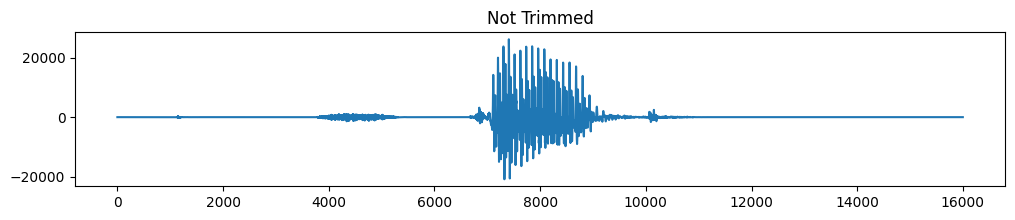

In [28]:
plt.figure(figsize=(12, 2))
plt.plot(data)
plt.title("Not Trimmed")

Positionen:  tf.Tensor([ 1139 10913], shape=(2,), dtype=int64)
tf.Tensor(1139, shape=(), dtype=int64) tf.Tensor(10913, shape=(), dtype=int64)


Text(0.5, 1.0, 'Trimmed')

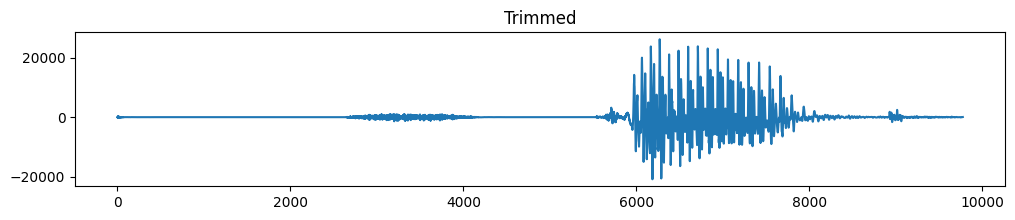

In [35]:
# Trim: 
# - input, axis, epsilon, name=None
# - Input: Data, Axis: welche Achse?, epsilon: Ab wann ist es noise? => siehe Dok. 
position = tfio.audio.trim(tf_audio_data, axis=0, epsilon=40)  # 0.1 

print("Positionen: ", position)

start = position[0]
stop  = position[1]
print(start, stop)

processed = tf_audio_data[start:stop]
plt.figure(figsize=(12, 2))
plt.plot(processed.numpy())
plt.title("Trimmed")

<h3>Fade</h3>

Erhöhe oder senke Stärke.

In [36]:
# Normal #
Audio(data, rate=16000)

In [45]:
# Fade 
# - input, fade_in, fade_out, mode, name=None
fade = tfio.audio.fade(
    processed, fade_in=7000, fade_out=8000, mode="logarithmic")

<h3>Spektrogramm</h3>

Man kann verschiedene Spektrogramme nutzen: Spektrogramm und Mel-Spektrogramm.

TensorFlow bietet Frequenz-Masking und Time-Masking an.

<h2>Pre-Trained (Transfer- und Fine-Tuning)</h2>

In diesem Abschnitt wollen wir ein Model nutzen und es an unsere Situation durch Fine-Tuning anpassen.

Die nutung eines Pre-Trained Models hat Vorteile. Größere Modelle müssen wir nicht selber trainieren und Sparen Zeit und Geld. Es gibt eine Vielzahl von Modellen, die wir nutzen können. Diese Modelle wurde mit mehreren Klassen trainiert und sind meist gut an bestimmte Probleme an angepasst worden.

Hier nutzen wir das Model YAMNet. Es wurde mit 521 Klassen trainiert. <br>

> Transfer learning with YAMNet for environmental sound classification: https://www.tensorflow.org/tutorials/audio/transfer_learning_audio [Letzter Zugriff: 12.09.2024]

> YAMNet GitHub https://github.com/tensorflow/models/tree/master/research/audioset/yamnet [Letzter Zugriff: 13.09.2024]


Das Model nutzt Frames der Größe 0.96s und extrahiert jede 0.48s. <br>
<u>Als Input</u>: 1D-Float32 Array, Waveform, Mono, 16kHz, Bereich [-1, 1]. <bR>
<u>Output:</u>: Klassen-Score, Embeddings und Log-Mel-Spektrogramm


Transfer-Learning: Aufgabenbereich hat geringere Ähnlichkeit mit dem, was das eigentliche Model lösen soll. <br>
Fine-Tuning: Aufgabenbereich ist ähnlich -> passe Gewichte an.

<h3>Transfer Learning</h3>

Transfer Learning- Nutze Model um Features zu Extrahieren

In [3]:
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)

Für die Veranschaulichung, gehen wir den ganzen Prozess durch.

In [128]:
DATASET_PATH = 'data/mini_speech_commands'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

In [129]:
# Dataset enthält Ordner mit Audiodateien.
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store')]
print(f'Kommandos: {commands}')

Kommandos: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


In [166]:
# Erstelle Dataset # 
main_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=32,
    seed=0,
    output_sequence_length=16000  # Padding 
    )
main_ds

Found 8000 files belonging to 8 classes.


<_BatchDataset element_spec=(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [167]:
label_names = main_ds.class_names
main_ds.class_names

['down', 'go', 'left', 'no', 'right', 'stop', 'up', 'yes']

In [168]:
# Bereite Dataset vor # 
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

main_ds = main_ds.map(squeeze, tf.data.AUTOTUNE)

Jetzt kümmern wir uns um das Model und der Extrahieren der Features.

In [169]:
# Unbatch- siehe Model Input # 
main_ds = main_ds.unbatch()

In [170]:
# Überprüfe Shape
for data_sample, label in main_ds:
    print(data_sample.numpy().max()) 
    break

data_sample

0.11187744


<tf.Tensor: shape=(16000,), dtype=float32, numpy=
array([0.00146484, 0.00457764, 0.00296021, ..., 0.00326538, 0.00256348,
       0.00369263], dtype=float32)>

In [171]:
# Embeddings: Shape (N, 1024), N: Anzahl der gefunden Frames, jede 0.48s
# - Extrahiere Embeddings. 
def extract_embedding(wav_data, label):
    scores, embeddings, spectrogram = yamnet_model(wav_data)
    num_embeddings = tf.shape(embeddings)[0]
    return (embeddings, tf.repeat(label, num_embeddings))            

In [172]:
main_ds = main_ds.map(extract_embedding, tf.data.AUTOTUNE).unbatch()
main_ds.element_spec

(TensorSpec(shape=(1024,), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int32, name=None))

In [173]:
main_ds = main_ds.shuffle(8000)

In [174]:
DATASET_SIZE = 8000
train_size = int(0.7 * DATASET_SIZE)
val_size   = int(0.15 * DATASET_SIZE)
test_size  = int(0.15 * DATASET_SIZE)

main_ds = main_ds.shuffle(8000)
train_dataset = main_ds.take(train_size)
test_dataset  = main_ds.skip(train_size)
val_dataset   = main_ds.skip(test_size)

In [175]:
train_dataset = train_dataset.cache().shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset  = test_dataset.cache().shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset   = val_dataset.cache().shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)

Dann erstellen wir das Model.

In [176]:
num_classes = len(label_names)
num_classes

8

In [177]:
for data_sample_2, label in train_ds:
    print(data_sample.numpy().max()) 
    break

0.11187744


In [178]:
data_sample_2

<tf.Tensor: shape=(32, 1024), dtype=float32, numpy=
array([[0.00839529, 0.        , 0.04795116, ..., 0.        , 0.        ,
        0.        ],
       [0.31316897, 0.13367836, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.0554015 , 0.0294424 , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.19116335, 0.        , 0.1536096 , ..., 0.        , 0.00628447,
        0.        ],
       [0.        , 0.4290032 , 0.        , ..., 0.06774725, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)>

In [183]:
transfer_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024,), dtype=tf.float32, name='input_embedding'),
    tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    #tf.keras.layers.Dense(units=255, activation="relu"),
    tf.keras.layers.Dense(units=num_classes)
])

transfer_model.compile(
    optimizer='adam',
    loss     = tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics  = ["accuracy"] 
)
transfer_model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_31 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 8)              │         4,104 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 528,904 (2.02 MB)

 Trainable params: 528,904 (2.02 MB)

 Non-trainable params: 0 (0.00 B)

In [184]:
transfer_model.fit(train_dataset, validation_data=val_dataset, epochs=20)

Epoch 1/20
    168/Unknown 1s 4ms/step - accuracy: 0.2289 - loss: 2.0978

C:\Users\Alexander\anaconda3\envs\tensorflow\lib\contextlib.py:137: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.2311 - loss: 2.0929 - val_accuracy: 0.3507 - val_loss: 1.7622
Epoch 2/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3592 - loss: 1.7352 - val_accuracy: 0.3897 - val_loss: 1.6430
Epoch 3/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4105 - loss: 1.5894 - val_accuracy: 0.4116 - val_loss: 1.5932
Epoch 4/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4440 - loss: 1.5049 - val_accuracy: 0.4363 - val_loss: 1.5349
Epoch 5/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4858 - loss: 1.4272 - val_accuracy: 0.4459 - val_loss: 1.5109
Epoch 6/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4959 - loss: 1.3641 - val_accuracy: 0.4732 - val_loss: 1.4582
Epoch 7/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5314 - loss: 1.3104 - val_accuracy: 0.4539 - val_loss: 1.4937
Epoch 8/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5468 - loss: 1.2597 - val_accuracy: 0.4881 - val_

In [185]:
transfer_model.evaluate(test_dataset, return_dict=True)

325/325 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step - accuracy: 0.5570 - loss: 1.3626


{'accuracy': 0.5649999976158142, 'loss': 1.3521184921264648}

<h3>Fine-Tune</h3>

Für das Fine-Tuning suchen wir uns ein Model das mit Audio umgehen kann. Dazu gehören auch Bildklassifizierungen im Rahmen von Spektrogrammen. Wir suchen ein Model speziell für Audioklassifizierungen, diese nicht so häufig auffindbar wie Modelle für Bildklassifizierungen. Bildklassifizierung können wir dank Spektrogramme trotzdem nutzen.

Für das Fine-Tuning müssen erstmal alle Layers des Models eingefroren werden.


In [149]:
# Suche Passendes Model, z. B.:
from tensorflow.keras.applications import MobileNetV2
# *Lese die Dok. des Models

base_model = MobileNetV2(input_shape=(128, 128, 3),  # Spektrogramm Bild. (_,_, RGB Channels) 
                         include_top=False,  
                         weights="imagenet")  # weights: wähle Gewichte 
# *Details der Layers auch in Dok.
base_model.trainable = False
# Untersten n-Layers können für das Training genutzt werden. Setze Layers. 

In [11]:
base_model.summary()

Model: "mobilenetv2_1.00_128"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        288 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,257,408 (8.61 MB)

 Trainable params: 2,223,296 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

Erstelle Dataset.

In [154]:
DATASET_PATH = 'data/mini_speech_commands'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

In [155]:
# Erstelle Dataset # 
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=32,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,  # Padding 
    subset='both')
train_ds

Found 8000 files belonging to 8 classes.
Using 6400 files for training.
Using 1600 files for validation.


<_BatchDataset element_spec=(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

Dann können wir das Dataset anpassen und Manipulieren.

In [156]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds   = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [157]:
# Erstelle Test- und Validationset #
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds  = val_ds.shard(num_shards=2, index=1)

In [158]:
# Passe ggf. an Model an.
def get_spectrogram(waveform):
   
    spectrogram = tf.signal.stft(waveform, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram)  
    spectrogram = spectrogram[..., tf.newaxis]

    spectrogram = tf.image.grayscale_to_rgb(spectrogram)  # Greyscale
    
    return spectrogram

In [159]:
# Wende auf Dataset an. #
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label), 
      num_parallel_calls=tf.data.AUTOTUNE)

In [160]:
# Funtion für oben, um Spektrogramm zu esretllen. 
train_ds_spec = make_spec_ds(train_ds)
val_ds_spec   = make_spec_ds(val_ds)
test_ds_spec  = make_spec_ds(test_ds)

In [161]:
for sample, _ in train_ds_spec:
    print(sample)
    break

tf.Tensor(
[[[[3.30325425e-01 3.30325425e-01 3.30325425e-01]
   [8.66495490e-01 8.66495490e-01 8.66495490e-01]
   [4.35491621e-01 4.35491621e-01 4.35491621e-01]
   ...
   [9.53209965e-05 9.53209965e-05 9.53209965e-05]
   [1.01160229e-04 1.01160229e-04 1.01160229e-04]
   [4.68045473e-05 4.68045473e-05 4.68045473e-05]]

  [[3.81234765e-01 3.81234765e-01 3.81234765e-01]
   [8.40707660e-01 8.40707660e-01 8.40707660e-01]
   [4.23843592e-01 4.23843592e-01 4.23843592e-01]
   ...
   [1.16305819e-04 1.16305819e-04 1.16305819e-04]
   [1.54061403e-04 1.54061403e-04 1.54061403e-04]
   [6.06477261e-05 6.06477261e-05 6.06477261e-05]]

  [[4.85456705e-01 4.85456705e-01 4.85456705e-01]
   [8.53497505e-01 8.53497505e-01 8.53497505e-01]
   [4.33158875e-01 4.33158875e-01 4.33158875e-01]
   ...
   [2.59493918e-05 2.59493918e-05 2.59493918e-05]
   [6.01581451e-05 6.01581451e-05 6.01581451e-05]
   [2.38567591e-05 2.38567591e-05 2.38567591e-05]]

  ...

  [[1.34500772e-01 1.34500772e-01 1.34500772e-01]
   [8

Jetzt kann das folgende Model genutzt werden, um ein Sequentielles oder anders Model zu erstellen.

In [164]:
# Füge Layers hinzu
# - Zusätzlich können layers für eine Transformation genutzt werden.
finetune_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(124, 129, 3)),
    tf.keras.layers.Resizing(height=128, width=128),
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),  
    tf.keras.layers.Dense(256, activation='relu'),  
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(8)  
])

finetune_model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = ["accuracy"]
    
)

In [165]:
fintune_history = finetune_model.fit(train_ds_spec, epochs=9, validation_data=val_ds_spec)

Epoch 1/9
200/200 ━━━━━━━━━━━━━━━━━━━━ 28s 122ms/step - accuracy: 0.3661 - loss: 1.7687 - val_accuracy: 0.6062 - val_loss: 1.1195
Epoch 2/9
200/200 ━━━━━━━━━━━━━━━━━━━━ 21s 104ms/step - accuracy: 0.6016 - loss: 1.1043 - val_accuracy: 0.6712 - val_loss: 0.9559
Epoch 3/9
200/200 ━━━━━━━━━━━━━━━━━━━━ 21s 104ms/step - accuracy: 0.6473 - loss: 0.9629 - val_accuracy: 0.7013 - val_loss: 0.8847
Epoch 4/9
200/200 ━━━━━━━━━━━━━━━━━━━━ 22s 111ms/step - accuracy: 0.6886 - loss: 0.8540 - val_accuracy: 0.6875 - val_loss: 0.8562
Epoch 5/9
200/200 ━━━━━━━━━━━━━━━━━━━━ 22s 108ms/step - accuracy: 0.7260 - loss: 0.7740 - val_accuracy: 0.6725 - val_loss: 0.8849
Epoch 6/9
200/200 ━━━━━━━━━━━━━━━━━━━━ 21s 104ms/step - accuracy: 0.7178 - loss: 0.7525 - val_accuracy: 0.6938 - val_loss: 0.8412
Epoch 7/9
200/200 ━━━━━━━━━━━━━━━━━━━━ 21s 105ms/step - accuracy: 0.7416 - loss: 0.6903 - val_accuracy: 0.7050 - val_loss: 0.8411
Epoch 8/9
200/200 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.7585 - loss: 0.6520 - 

In [166]:
finetune_model.evaluate(test_ds_spec, return_dict=True)

25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.7058 - loss: 0.9583


{'accuracy': 0.6912500262260437, 'loss': 0.9151952862739563}

Man sieht, dass die Performance nicht schlecht ist.

Key-Notes:
- Welches Problem will ich mit welchem Model lösen?
- Mit welchen Daten wurde das Model trainiert?
- Welche Parameter kann ich einstellen?
- Was steht in der Model Dokumentation? -> Meist sind Beispiele dabei. 
- Wie muss der Input des Models?
- Was liefert das Model am Ende? -> Feature Extraction? -> Transfer-Learning (mit anpassungen Fine-Tune Model)
- Welche Layers füge ich hinzu? -> Dens, RNN, Reshape, Resize, CNN, ...

<h3>Prediction</h3>

Des Weiteren können wir wie üblich vorgehen, hier wollen wir einzelne Predictions durchführen.

<b>*</b> Hier ohne Padding

In [176]:
# Ziehe Random # 
random_command = np.random.randint(1, len(label_names)-1)
random_command = label_names[random_command]

listed_audio_files = os.listdir(DATASET_PATH+f"/{random_command}")

samplerate, data = wavfile.read(DATASET_PATH+f"/{random_command}/{listed_audio_files[6]}")
print(f"Kommando: {random_command}")
print(f"number of channels = {data.shape[0]}")

length = data.shape[0] / samplerate
print(f"Länge = {length}s")

Kommando: no
number of channels = 16000
Länge = 1.0s


In [177]:
Audio(data, rate=16000)

In [181]:
data_sample = tf.convert_to_tensor(data)  # Zu Tensor 
data_sample = data_sample / np.max(np.abs(data_sample))  # Normalisiere

# Spektrogramm #
spectrogram = tf.signal.stft(data_sample, frame_length=255, frame_step=128)
spectrogram = tf.abs(spectrogram)  
spectrogram = spectrogram[..., tf.newaxis]
spectrogram = tf.image.grayscale_to_rgb(spectrogram)  # Grayscale

spectrogram.numpy().shape[:]  # Reshape/Resize/... im Model.

(124, 129, 3)

In [190]:
# Füge Batch-Dimension ein # 
spectrogram = tf.expand_dims(spectrogram, axis=0)

In [192]:
spectrogram.numpy().shape[:] 

(1, 124, 129, 3)

In [193]:
res = finetune_model.predict(spectrogram)
res

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 880ms/step


array([[ 3.6050603,  1.9968958, -2.3941581,  4.538964 ,  1.2820643,
        -5.705302 , -5.222422 , -3.8799286]], dtype=float32)

In [195]:
class_index = np.argmax(tf.nn.softmax(res))
dict_labels[class_index]

'no'